## Verizon 
* Tried to use `complete_difference_provider_district_level` on Verizon a few times. 
* Always stopped at `Verizon_no_coverage_d8.parquet`. 
* Run the rest of the districts to have a complete Verizon shapefile using the function above in a more reproducible way.

In [1]:
import dask.dataframe as dd
import dask_geopandas as dg
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely.wkt
import A1_provider_prep
import A2_analysis
import A3_other
from calitp.sql import to_snakecase
from shared_utils import geography_utils, utils

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
import gcsfs
from calitp.storage import get_fs
fs = get_fs()

In [3]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [4]:
# Read in og Verizon
verizon = dg.read_parquet("Verizon.parquet")

In [5]:
districts = A1_provider_prep.get_districts()

### First find districts that are missing in a reproducible way...
* https://github.com/cal-itp/data-analyses/blob/main/daskify_rt/A4_speeds_by_segment_trip.py#L45-L58

In [6]:
def find_missing_districts():
    # List of all files in my cell coverage folder
    all_files_in_folder = fs.ls(A1_provider_prep.GCS_FILE_PATH)
    
    # Grab only files with the string "Verizon_no_coverage_"
    files = [i for i in all_files_in_folder if "Verizon_no_coverage_" in i]
    
    # Find the districts that I have files for 
    districts_already_run =[i.split('no_coverage_d')[1] for i in files]
    
    # Get rid of .parquet
    districts_already_run = [i.split('.parquet')[0] for i in districts_already_run]
    
    # Turn values into an integer
    districts_already_run = [int(i) for i in districts_already_run]
    
    # All districts 
    all_districts = [*range(1, 13, 1)]
    
    # list of districts I still have to run function on 
    missing_districts = list(set(all_districts) - set(districts_already_run))
    
    return missing_districts

In [7]:
# verizon_missing_dist = find_missing_districts()

In [8]:
# verizon_missing_dist

In [9]:
# files = [i for i in all_files_in_folder if "Verizon_no_coverage_" in i]
  

In [10]:
# districts_already_run =[i.split('no_coverage_d')[1] for i in files]

In [11]:
#districts = [i.split('.parquet')[0] for i in districts]

In [12]:
#districts = [int(i) for i in districts]

In [13]:
#all_districts = [*range(1, 13, 1)]

In [14]:
#missing_districts = list(set(all_districts) - set(districts))

### Run the function for the missing districts

In [15]:
def complete_difference_provider_district_level(
    provider_df: dg.GeoDataFrame, 
    district_df: gpd.GeoDataFrame,
    file_name: str,
    districts_needed:list) -> dg.GeoDataFrame:
    
    full_gdf = pd.DataFrame()
    
    for i in districts_needed:
        result = A1_provider_prep.iloc_find_difference_district(
            provider_df, 
            district_df[district_df.district==i],
            provider_name
        )

        full_gdf = dd.multi.concat([full_gdf, result], axis=0)
    
    full_gdf = full_gdf.compute()
    
    utils.geoparquet_gcs_export(full_gdf, A1_provider_prep.GCS_FILE_PATH, file_name)
    return full_gdf

In [16]:
# verizon_9_12 = complete_difference_provider_district_level(verizon, districts, 'verizon', verizon_missing_dist)

### Piece together the other files that worked last time...

In [17]:
# v_d9_d12 = gpd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/cellular_coverage/d9_to_d12_verizon_no_coverage_complete_CA.parquet"
# )

In [18]:
# v_d9_d12.shape

(4, 1)

In [19]:
# all_files_in_folder = fs.ls(A1_provider_prep.GCS_FILE_PATH)

In [20]:
# Grab only files with the string "Verizon_no_coverage_"
# verizon_files = [i for i in all_files_in_folder if "Verizon_no_coverage_" in i]

In [21]:
# my_string = "gs://"

In [22]:
# verizon_files = [my_string + i for i in verizon_files]

In [23]:
# v_d1_d8= dd.multi.concat([gpd.read_parquet(f) for f in verizon_files])

In [24]:
# v_d1_d8 = v_d1_d8.compute()

In [26]:
verizon_all_gdf = [v_d1_d8, v_d9_d12]

In [27]:
# v_complete = A1_provider_prep.concat_all_areas(verizon_all_gdf, A1_provider_prep.GCS_FILE_PATH, "verizon_no_coverage_complete_CA")

Saved to GCS


In [28]:
v_all = gpd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/cellular_coverage/verizon_no_coverage_complete_CA.parquet"
)

<AxesSubplot:>

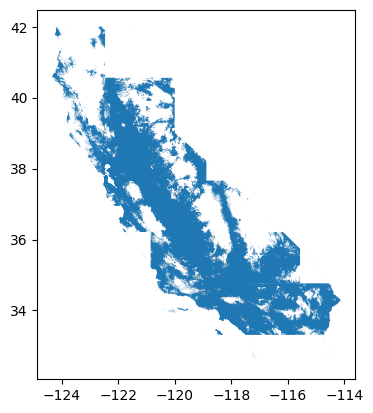

In [32]:
A1_provider_prep.load_att().plot()

<AxesSubplot:>

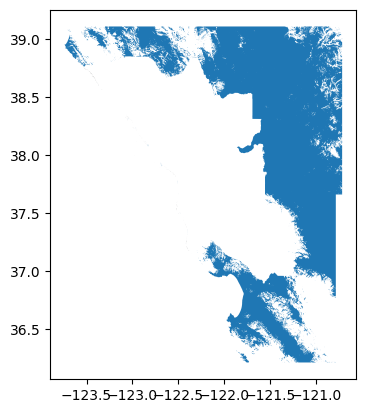

In [31]:
gpd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/cellular_coverage/ATT_no_coverage_d4.parquet"
).plot()